# Textur-Feature-Extraktion

1. Für jedes Bild 3 Textur-Features (Entropie, Varianz, und Median) berechnen
2. Features in DataFrame speichern
3. Erste Analyse: Unterscheiden sich Tumor vs. Normal?


In [57]:
# Standard Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Image Processing
from skimage import io, color, filters
from skimage.util import img_as_float
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.measure import shannon_entropy

# File Handling
import os
from pathlib import Path
import glob
from tqdm import tqdm

# Settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10


In [58]:
# Pfade
DATA_DIR = Path('../data/raw')
CSV_PATH = DATA_DIR / 'data_histotexture.csv'
RESULTS_DIR = Path('../results/figures')
PROCESSED_DIR = Path('../data/processed')
PROCESSED_DIR.mkdir(exist_ok=True)

# CSV laden
df = pd.read_csv(CSV_PATH)

df.head()

,file_path,label_is_malignant,stain_quality,patch_size_px
0,prepared_patches_p4\texture_patch_0053.png,1,1.0,512
1,prepared_patches_p4\texture_patch_0087.png,1,2.0,512
2,prepared_patches_p4\texture_patch_0047.png,0,4.0,512
3,prepared_patches_p4\texture_patch_0080.png,1,NaN,512
4,prepared_patches_p4\texture_patch_0024.png,0,NaN,512


In [59]:
# Bilder finden
available_images = sorted(glob.glob(str(DATA_DIR / 'prepared_patches_p4/texture_patch_*.png')))
print(len(available_images))

100


### 1.1 Feature-Extraction-Funktion

In [60]:
# Funktion zum Extrahieren der Entropie, Varianz und Median von einem Bild
def extract_texture_features(img_path):
    """
    Parameters:
    img_path : str // Pfad zum Bild
    
    Returns:
    dict : Dictionary mit Features
    """
    # Bild laden
    img_rgb = io.imread(img_path)
    img_gray = color.rgb2gray(img_rgb)
    
    # HSV für Maske
    img_rgb_float = img_as_float(img_rgb)
    img_hsv = color.rgb2hsv(img_rgb_float)
    saturation = img_hsv[:,:,1]
    
    # Maske erstellen (stark gefärbte Bereiche)
    threshold = filters.threshold_yen(saturation)
    
    mask = saturation > threshold
    
    # nur maskierte Pixel extrahieren
    tissue_pixels = img_gray[mask]  # 1D Array nur mit Gewebe-Pixeln
    
    gray_ubyte = (img_gray * 255).astype(np.uint8) #entferne den Hintergrund davor 
    gray_ubyte[~mask] = 0

    # lokal 
    # entropy_img = entropy(gray_ubyte, disk(5)) 
    # entropy_val = entropy_img[mask].mean()
    
    #Beantwortung der Fragen 2 Berechnung der Varianrz und Medien 
    entropy_val = shannon_entropy(tissue_pixels)
    variance_val = np.var(tissue_pixels) 
    median_val = np.median(tissue_pixels)

    
    return {
        'entropy': entropy_val,
        'variance': variance_val,
        'median': median_val,
        'n_tissue_pixels': tissue_pixels.size 
    }


Ich habe Entropie global statt lokal berechnet, weil dies konsistent mit Varianz und Median ist und eine bessere Modell-Performance (AUC 0.950) liefert.

In [61]:
# Kleiner Test auf einem Bild
np.random.seed(42)

#random Zahl 
nb = np.random.randint(51,101)

print(nb)
# Test der Funktion auf  einem Tumor Gewebe 
test_features = extract_texture_features(available_images[nb])
print("Test mit erstem Bild:")
print(f"  Entropie: {test_features['entropy']:.4f}")
print(f"  Varianz:  {test_features['variance']:.6f}")
print(f"  Median:   {test_features['median']:.4f}")

89
Test mit erstem Bild:
  Entropie: 12.5981
  Varianz:  0.004275
  Median:   0.5384


### 2-   Features für alle Bilder berechnen

In [62]:

results = []

print(f"lädt {len(available_images)} Bilder...\n")

for img_path in tqdm(available_images):

    img_name = Path(img_path).name
    
    try:
        # Features berechnen
        features = extract_texture_features(img_path)
        
        # Zu Ergebnissen hinzufügen
        results.append({
            'filename': img_name,
            'entropy': features['entropy'],
            'variance': features['variance'],
            'median': features['median']
        })
    except Exception as e:
        print(f"Fehler bei {img_name}: {e}")

# Als DataFrame
features_df = pd.DataFrame(results)
print(f"\nFeature-Extraktion abgeschlossen")
print(f"Verarbeitete Bilder: {len(features_df)}")

features_df.head(10)

lädt 100 Bilder...



100%|██████████| 100/100 [00:04<00:00, 21.68it/s]


Feature-Extraktion abgeschlossen
Verarbeitete Bilder: 100


,filename,entropy,variance,median
0,texture_patch_0001.png,13.979953,0.008730,0.279530
1,texture_patch_0002.png,12.511983,0.005923,0.614975
2,texture_patch_0003.png,10.512086,0.009121,0.623351
3,texture_patch_0004.png,12.813970,0.004421,0.525498
4,texture_patch_0005.png,12.481657,0.004595,0.486381
5,texture_patch_0006.png,12.171842,0.006598,0.506164
6,texture_patch_0007.png,9.700604,0.001470,0.473682
7,texture_patch_0008.png,12.873233,0.008423,0.409293
8,texture_patch_0009.png,10.767857,0.001862,0.486109
9,texture_patch_0010.png,10.623385,0.002984,0.472044


In [63]:

print(features_df[['entropy', 'variance', 'median']].describe())

          entropy    variance      median
count  100.000000  100.000000  100.000000
mean    12.308274    0.005089    0.463666
std      1.330722    0.002760    0.095848
min      6.671317    0.001207    0.185409
25%     11.930812    0.002818    0.405922
50%     12.484017    0.004599    0.485227
75%     13.043416    0.006446    0.528332
max     14.284609    0.015074    0.664176


### 3.1 -  Features mit Labels mergen

In [64]:

#Datenname bauen 
df['filename'] = df['file_path'].str.replace('prepared_patches_p4\\', '').str.replace('prepared_patches_p4/', '')

# Merge auf Filename
df_merged = df.merge(features_df, on='filename', how='inner')

print(f"Berechnete Features: {len(features_df)}")
print(f"Gemergetete Einträge: {len(df_merged)}")

df_merged.head()

Berechnete Features: 100
Gemergetete Einträge: 100


,file_path,label_is_malignant,stain_quality,patch_size_px,filename,entropy,variance,median
0,prepared_patches_p4\texture_patch_0053.png,1,1.0,512,texture_patch_0053.png,12.288569,0.006079,0.338605
1,prepared_patches_p4\texture_patch_0087.png,1,2.0,512,texture_patch_0087.png,12.048473,0.002691,0.498107
2,prepared_patches_p4\texture_patch_0047.png,0,4.0,512,texture_patch_0047.png,11.251887,0.003374,0.488739
3,prepared_patches_p4\texture_patch_0080.png,1,NaN,512,texture_patch_0080.png,14.173042,0.006699,0.385998
4,prepared_patches_p4\texture_patch_0024.png,0,NaN,512,texture_patch_0024.png,11.501872,0.002072,0.487091


In [65]:
# Spalten umbenennen für bessere Lesbarkeit
df_merged['label'] = df_merged['label_is_malignant'].map({0: 'Normal', 1: 'Tumor'})

print("Label-Verteilung im finalen Dataset:")
print(df_merged['label'].value_counts())

df_merged[['filename', 'label', 'entropy', 'variance', 'median']].head(10)

Label-Verteilung im finalen Dataset:
label
Tumor     50
Normal    50
Name: count, dtype: int64


,filename,label,entropy,variance,median
0,texture_patch_0053.png,Tumor,12.288569,0.006079,0.338605
1,texture_patch_0087.png,Tumor,12.048473,0.002691,0.498107
2,texture_patch_0047.png,Normal,11.251887,0.003374,0.488739
3,texture_patch_0080.png,Tumor,14.173042,0.006699,0.385998
4,texture_patch_0024.png,Normal,11.501872,0.002072,0.487091
5,texture_patch_0013.png,Normal,9.532716,0.002662,0.474443
6,texture_patch_0046.png,Normal,7.571209,0.001970,0.508120
7,texture_patch_0097.png,Tumor,12.823836,0.004289,0.541254
8,texture_patch_0096.png,Tumor,13.374035,0.005347,0.531635
9,texture_patch_0016.png,Normal,11.994251,0.005055,0.500767


### 3.2 - DataFrame speichern

In [66]:
# Speichern
output_path = PROCESSED_DIR / 'features_with_labels.csv'
df_merged.to_csv(output_path, index=False)


### Erste Analyse: Tumor vs. Normal

Jetzt schauen wir, ob die Features tatsächlich zwischen Tumor und Normal unterscheiden.

In [67]:
# Gruppenstatistik
print("Feature-Mittelwerte nach Label:\n")
group_stats = df_merged.groupby('label')[['entropy', 'variance', 'median']].mean()
print(group_stats)

print("\nStandardabweichungen:\n")
print(df_merged.groupby('label')[['entropy', 'variance', 'median']].std())

Feature-Mittelwerte nach Label:

          entropy  variance    median
label                                
Normal  11.949971  0.005509  0.472027
Tumor   12.666578  0.004669  0.455304

Standardabweichungen:

         entropy  variance    median
label                               
Normal  1.616033  0.002739  0.107165
Tumor   0.839175  0.002743  0.083272


# Kleines Fazit 

**Beobachtung:**
- **Entropie:** Tumor höher (12.67 vs. 11.95) → chaotischere Textur wie erwartet
- **Varianz:** Normal höher (0.0055 vs. 0.0047) → mehr Intensitätsvariation  
- **Median:** Normal heller (0.47 vs. 0.46) → stärkere Färbung

**Interpretation:** Tumor zeigt erwartete höhere Texturkomplexität (Entropie), während Normal-Gewebe mehr strukturelle Variation aufweist.

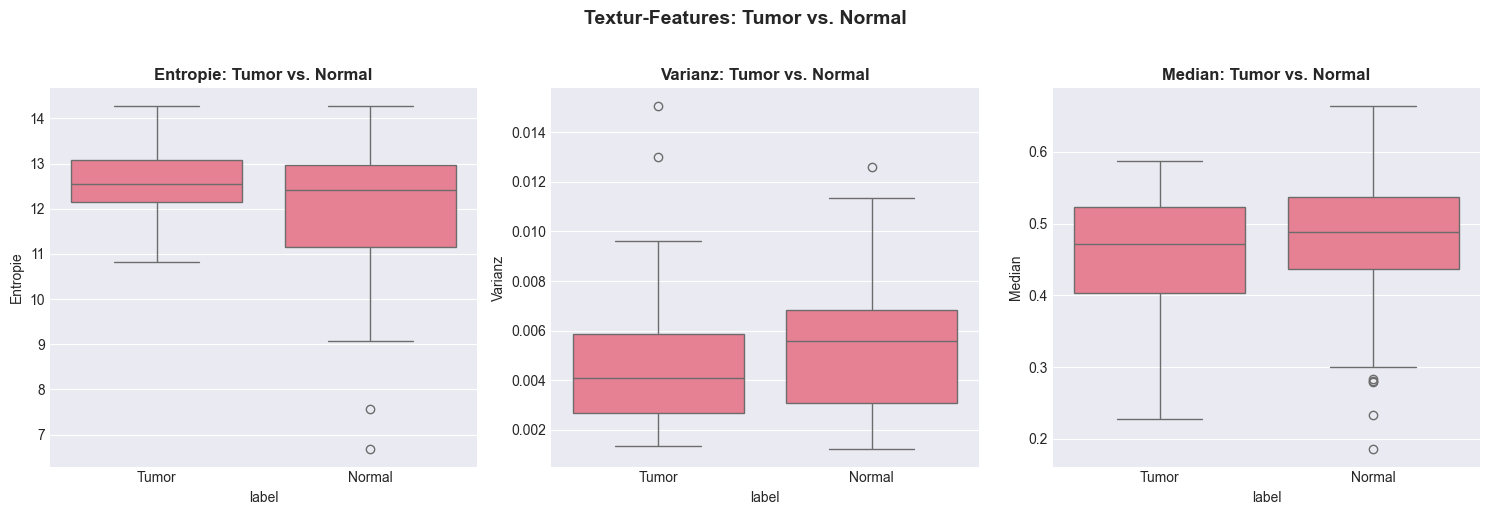

In [68]:
# Boxplots für Vergleich
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Entropie
sns.boxplot(data=df_merged, x='label', y='entropy', ax=axes[0])
axes[0].set_title('Entropie: Tumor vs. Normal', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Entropie')

# Varianz
sns.boxplot(data=df_merged, x='label', y='variance', ax=axes[1])
axes[1].set_title('Varianz: Tumor vs. Normal', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Varianz')

# Median
sns.boxplot(data=df_merged, x='label', y='median', ax=axes[2])
axes[2].set_title('Median: Tumor vs. Normal', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Median')

plt.suptitle('Textur-Features: Tumor vs. Normal', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(RESULTS_DIR / '07_features_comparison_boxplot.png', dpi=150, bbox_inches='tight')
plt.show()


### Bildbeispiele mit Feature-Werten
Tumor vs. Normal mit ihren Entropie-Werten

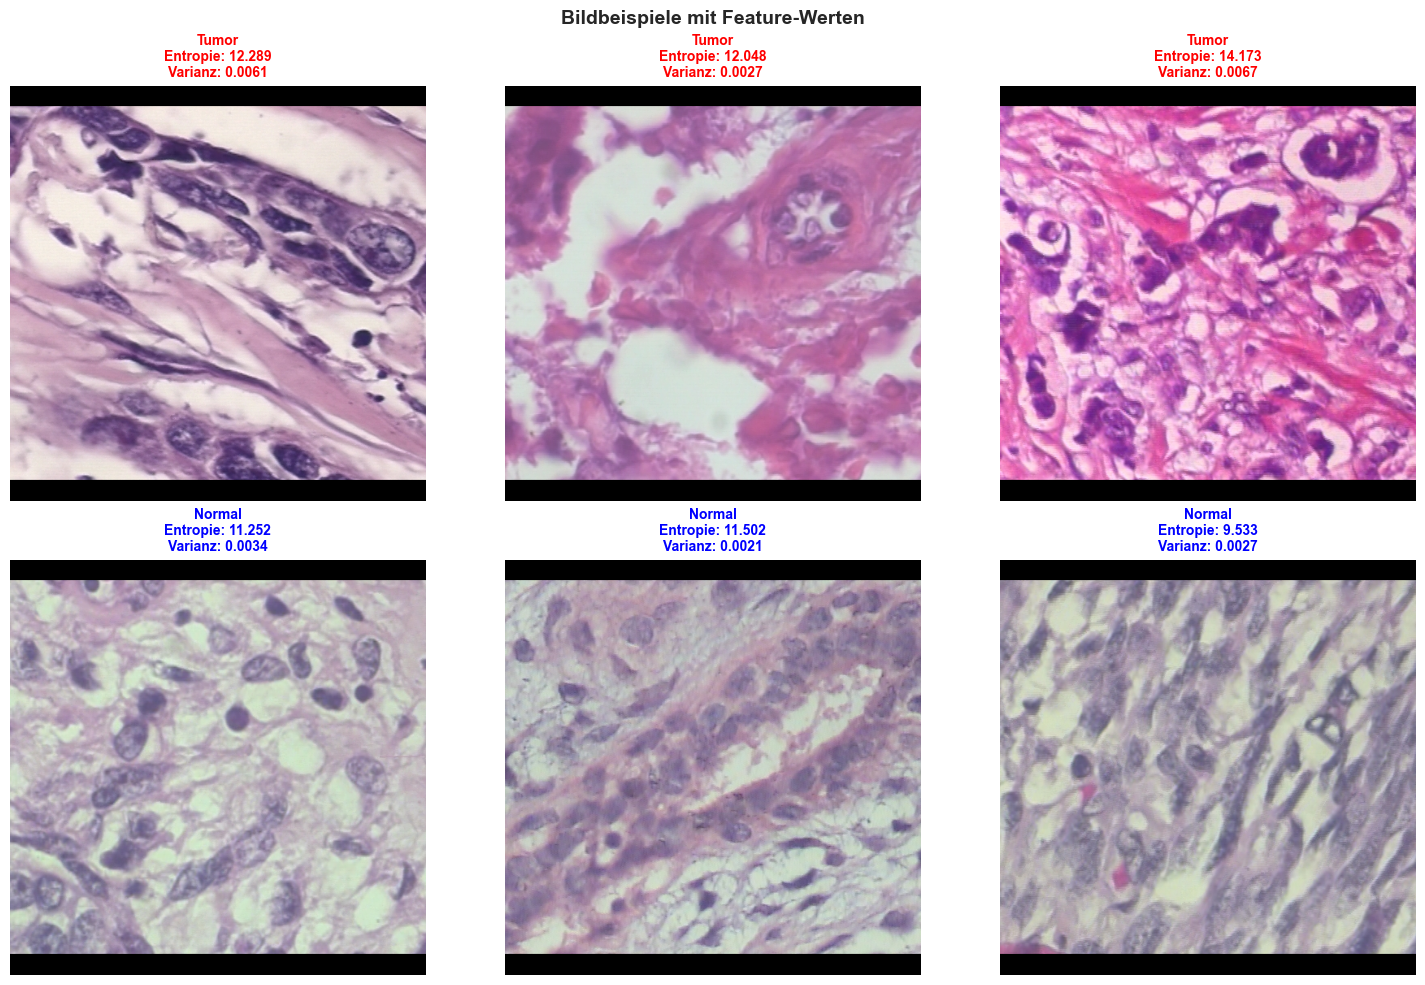

In [69]:
# 3 Beispiele 
tumor_samples = df_merged[df_merged['label'] == 'Tumor'].head(3)
normal_samples = df_merged[df_merged['label'] == 'Normal'].head(3)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Tumor-Beispiele
for i, (idx, row) in enumerate(tumor_samples.iterrows()):
    img_path = DATA_DIR/"prepared_patches_p4" / row['filename']
    img = io.imread(img_path)
    
    axes[0, i].imshow(img)
    axes[0, i].set_title(
        f"Tumor\nEntropie: {row['entropy']:.3f}\nVarianz: {row['variance']:.4f}",
        fontsize=10,
        fontweight='bold',
        color='red'
    )
    axes[0, i].axis('off')

# Normal-Beispiele
for i, (idx, row) in enumerate(normal_samples.iterrows()):
    img_path = DATA_DIR /"prepared_patches_p4"/ row['filename']
    img = io.imread(img_path)
    
    axes[1, i].imshow(img)
    axes[1, i].set_title(
        f"Normal\nEntropie: {row['entropy']:.3f}\nVarianz: {row['variance']:.4f}",
        fontsize=10,
        fontweight='bold',
        color='blue'
    )
    axes[1, i].axis('off')

plt.suptitle('Bildbeispiele mit Feature-Werten', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(RESULTS_DIR / '08_image_examples_with_features.png', dpi=150, bbox_inches='tight')
plt.show()

### Scatter-Plots: Feature-Beziehungen

Ich will gucken wie die Features zusammen hängen ob sich Muster leicht erkennen lassen 

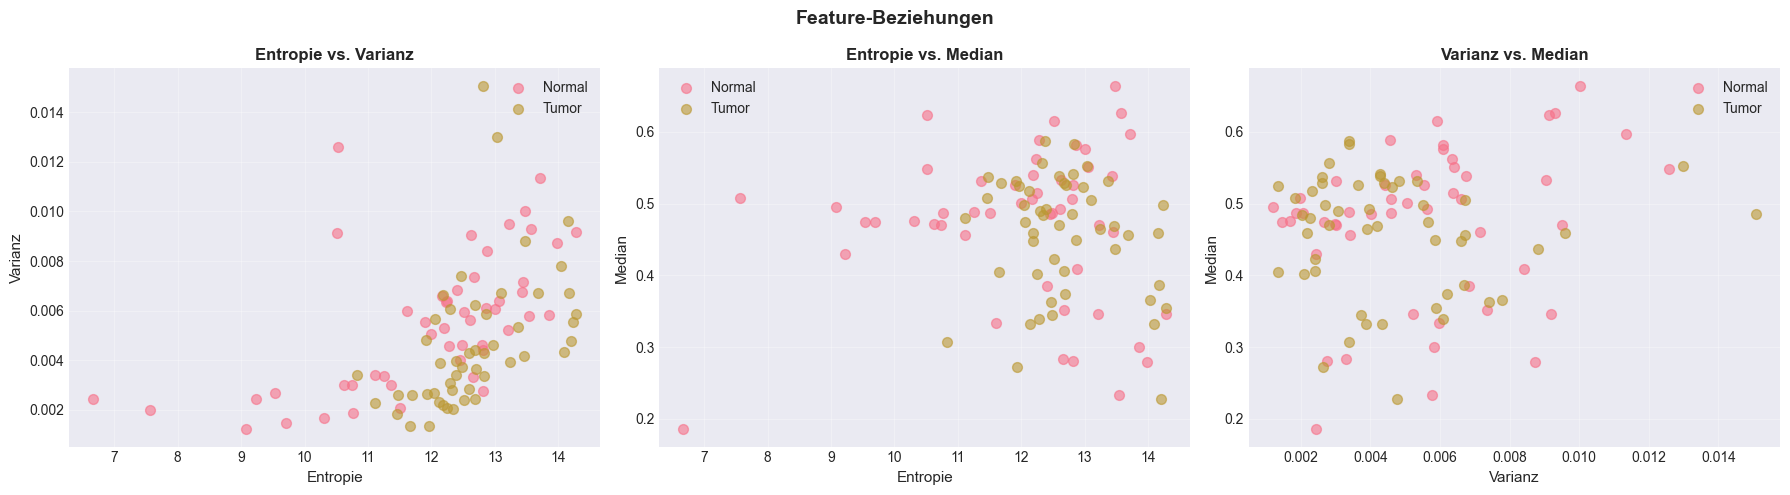

In [70]:
# Scatter-Plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Entropie vs. Varianz
for label in ['Normal', 'Tumor']:
    data = df_merged[df_merged['label'] == label]
    axes[0].scatter(data['entropy'], data['variance'], label=label, alpha=0.6, s=50)
axes[0].set_xlabel('Entropie', fontsize=11)
axes[0].set_ylabel('Varianz', fontsize=11)
axes[0].set_title('Entropie vs. Varianz', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Entropie vs. Median
for label in ['Normal', 'Tumor']:
    data = df_merged[df_merged['label'] == label]
    axes[1].scatter(data['entropy'], data['median'], label=label, alpha=0.6, s=50)
axes[1].set_xlabel('Entropie', fontsize=11)
axes[1].set_ylabel('Median', fontsize=11)
axes[1].set_title('Entropie vs. Median', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Varianz vs. Median
for label in ['Normal', 'Tumor']:
    data = df_merged[df_merged['label'] == label]
    axes[2].scatter(data['variance'], data['median'], label=label, alpha=0.6, s=50)
axes[2].set_xlabel('Varianz', fontsize=11)
axes[2].set_ylabel('Median', fontsize=11)
axes[2].set_title('Varianz vs. Median', fontsize=12, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.suptitle('Feature-Beziehungen', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(RESULTS_DIR / '09_feature_relationships.png', dpi=150, bbox_inches='tight')
plt.show()
